# Part 1

## Different datasets for testing

Implement simple CNN binary classification using two simple datasets:
- difference between the sun and moon
- difference between an office and a cafeteria

In [1]:
#imports from dl1

# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

/Users/vathsala/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
sz = 224

### Dataset 1: Difference between sun and moon

In [5]:
PATH = "data/sunmoon/"
dl_path = "data/downloads/"

In [6]:
os.makedirs('data/sunmoon/models', exist_ok=True)
os.makedirs('data/sunmoon/train/sun', exist_ok=True)
os.makedirs('data/sunmoon/train/moon', exist_ok=True)
os.makedirs('data/sunmoon/valid/sun', exist_ok=True)
os.makedirs('data/sunmoon/valid/moon', exist_ok=True)

In [7]:
os.listdir(PATH)

['valid', 'models', 'train']

In [8]:
# 80% images in train and 20% in valid
files = os.listdir(f'{dl_path}sun')

tr_val_split = int(len(files) * 0.2)
[os.rename(f'{dl_path}sun/{f}', f'{PATH}valid/sun/sun_{i}') for i, f in enumerate(files[:tr_val_split])];
[os.rename(f'{dl_path}sun/{f}', f'{PATH}train/sun/sun_{i}') for i, f in enumerate(files[tr_val_split:])];

In [10]:
files = os.listdir(f'{dl_path}moon')

tr_val_split = int(len(files) * 0.2)
[os.rename(f'{dl_path}moon/{f}', f'{PATH}valid/moon/moon_{i}') for i, f in enumerate(files[:tr_val_split])];
[os.rename(f'{dl_path}moon/{f}', f'{PATH}train/moon/moon_{i}') for i, f in enumerate(files[tr_val_split:])];

In [15]:
files = os.listdir(f'{PATH}valid/sun')[:5]
files

['sun_15', 'sun_12', 'sun_5', 'sun_2', 'sun_3']

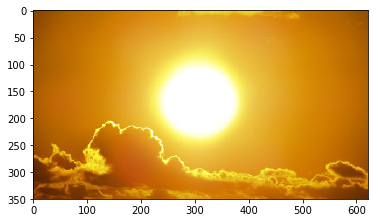

In [18]:
img = plt.imread(f'{PATH}valid/sun/{files[4]}')
plt.imshow(img);

In [19]:
files = os.listdir(f'{PATH}valid/moon')[:5]
files

['moon_1', 'moon_6', 'moon_8', 'moon_9', 'moon_7']

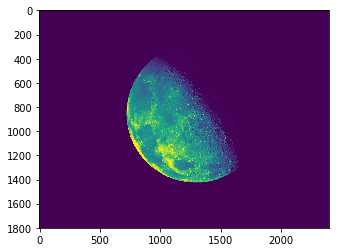

In [20]:
img = plt.imread(f'{PATH}valid/moon/{files[0]}')
plt.imshow(img);

### Model

In [33]:
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

conv_arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(conv_arch, sz))

model = ConvLearner.pretrained(conv_arch, data, precompute=True)

100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


In [34]:
model.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                
    0      0.875269   0.510696   0.756757  
    1      0.656409   0.321268   0.891892  
    2      0.489014   0.256867   0.891892  



[array([0.25687]), 0.8918918918918919]

In [35]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = model.predict()
log_preds.shape

(37, 2)

In [36]:
log_preds[:10]

array([[-0.01943, -3.95041],
       [-0.22693, -1.59443],
       [-0.03242, -3.44518],
       [-0.05665, -2.89908],
       [-0.1596 , -1.91382],
       [-0.41506, -1.07969],
       [-0.01153, -4.46813],
       [-0.00523, -5.25544],
       [-1.75833, -0.18914],
       [-0.78909, -0.60561]], dtype=float32)

In [37]:
preds = np.argmax(log_preds, axis=1)
# 0 is prob of cat, 1 prob of dog
probs = np.exp(log_preds[:, 1])

#### Visualising the results

In [38]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly classified


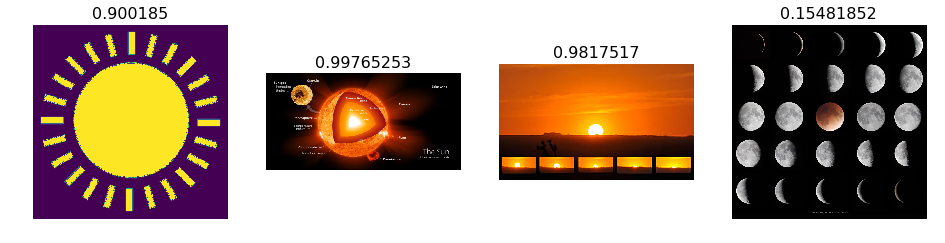

In [39]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Most correct moons


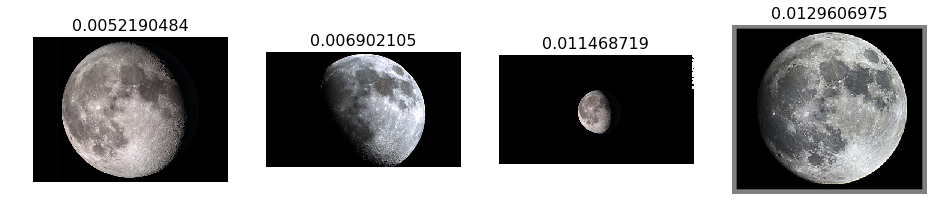

In [40]:
plot_val_with_title(most_by_correct(0, True), "Most correct moons")

Most correct suns


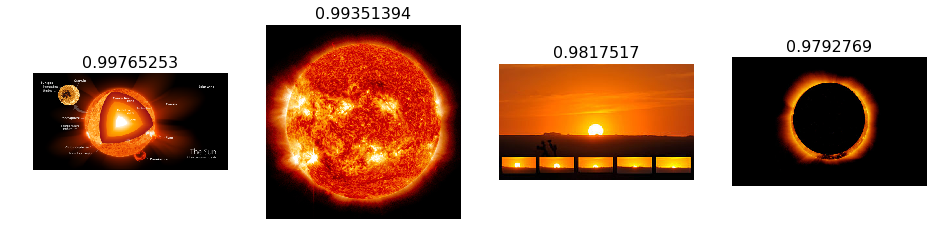

In [41]:
plot_val_with_title(most_by_correct(1, True), "Most correct suns")

Most incorrect moons


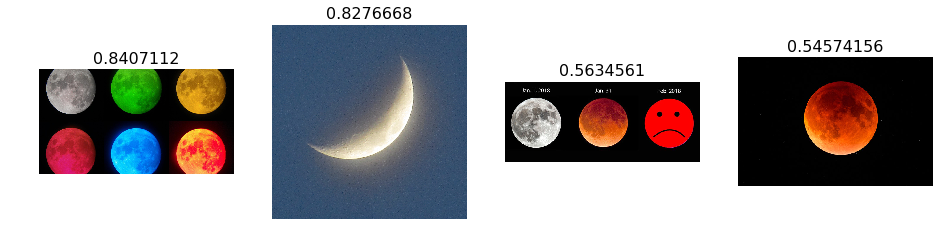

In [42]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect moons")

In [43]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect suns")

Most incorrect suns


<Figure size 1152x576 with 0 Axes>

Most uncertain predictions


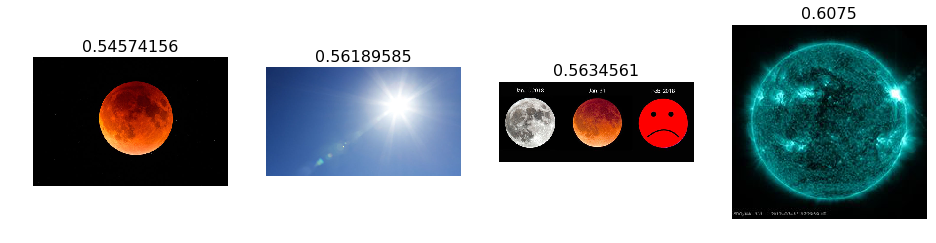

In [44]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### Dataset 2: Difference between offices and cafeterias



In [45]:
PATH = "data/officecafe/"

os.makedirs('data/officecafe/models', exist_ok=True)
os.makedirs('data/officecafe/train/office', exist_ok=True)
os.makedirs('data/officecafe/train/cafe', exist_ok=True)
os.makedirs('data/officecafe/valid/office', exist_ok=True)
os.makedirs('data/officecafe/valid/cafe', exist_ok=True)

In [46]:
# 80% images in train and 20% in valid
files = os.listdir(f'{dl_path}office')

tr_val_split = int(len(files) * 0.2)
[os.rename(f'{dl_path}office/{f}', f'{PATH}valid/office/office_{i}.jpg') for i, f in enumerate(files[:tr_val_split])];
[os.rename(f'{dl_path}office/{f}', f'{PATH}train/office/office_{i}.jpg') for i, f in enumerate(files[tr_val_split:])];

In [47]:
files = os.listdir(f'{dl_path}cafeteria')

tr_val_split = int(len(files) * 0.2)
[os.rename(f'{dl_path}cafeteria/{f}', f'{PATH}valid/cafe/cafe_{i}.jpg') for i, f in enumerate(files[:tr_val_split])];
[os.rename(f'{dl_path}cafeteria/{f}', f'{PATH}train/cafe/cafe_{i}.jpg') for i, f in enumerate(files[tr_val_split:])];

In [49]:
files = os.listdir(f'{PATH}valid/office')[:5]
files

['office_8.jpg',
 'office_9.jpg',
 'office_18.jpg',
 'office_12.jpg',
 'office_13.jpg']

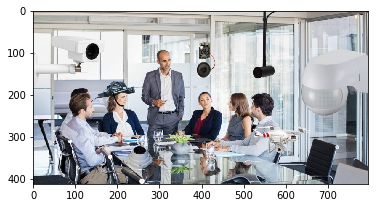

In [50]:
img = plt.imread(f'{PATH}valid/office/{files[1]}')
plt.imshow(img);

In [51]:
files = os.listdir(f'{PATH}valid/cafe')[:5]
files

['cafe_8.jpg', 'cafe_9.jpg', 'cafe_18.jpg', 'cafe_13.jpg', 'cafe_12.jpg']

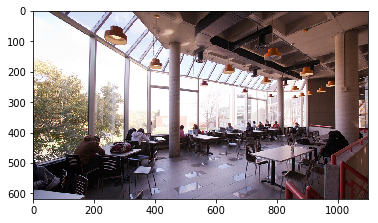

In [52]:
img = plt.imread(f'{PATH}valid/cafe/{files[1]}')
plt.imshow(img);

In [74]:
# model
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

# used the resnet 50
# conv_arch = resnet50
conv_arch = vgg16
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(conv_arch, sz))

model = ConvLearner.pretrained(conv_arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /Users/vathsala/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [01:32<00:00, 5959292.30it/s]


100%|██████████| 1/1 [00:17<00:00, 17.13s/it]


In [75]:
model.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.919252   0.632004   0.666667  
    1      0.765529   0.539379   0.888889  



[array([0.53938]), 0.8888888888888888]

In [76]:
log_preds = model.predict()
log_preds.shape

(36, 2)

In [77]:
# pred of class 0 or 1
preds = np.argmax(log_preds, axis=1)
# prob pred of office 
probs = np.exp(log_preds[:, 1])

#### Visualising the results

Correctly classified


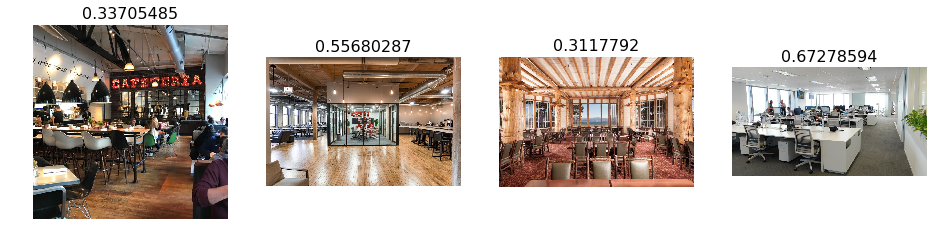

In [78]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [79]:
# 2. A few incorrect labels at random
# plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct cafes


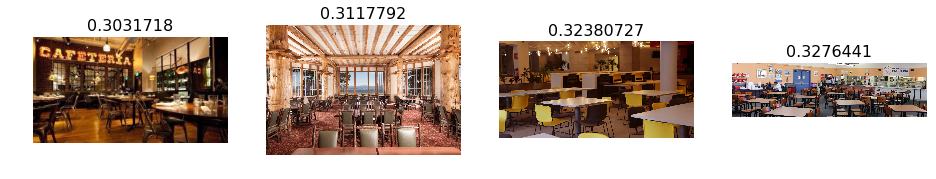

In [80]:
plot_val_with_title(most_by_correct(0, True), "Most correct cafes")

Most correct offices


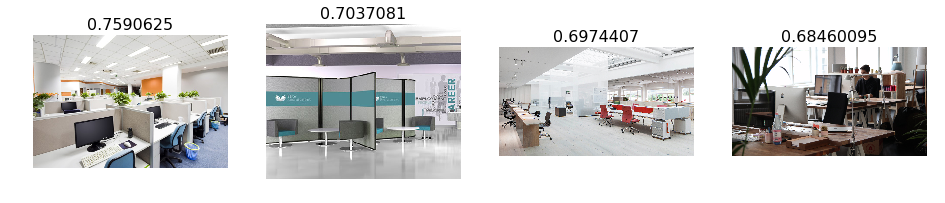

In [81]:
plot_val_with_title(most_by_correct(1, True), "Most correct offices")

Most incorrect cafes


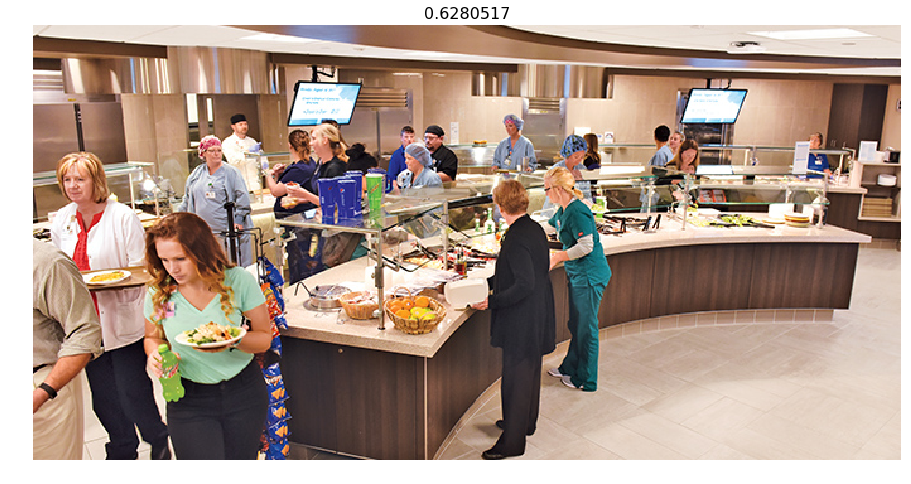

In [82]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cafes")

Most incorrect offices


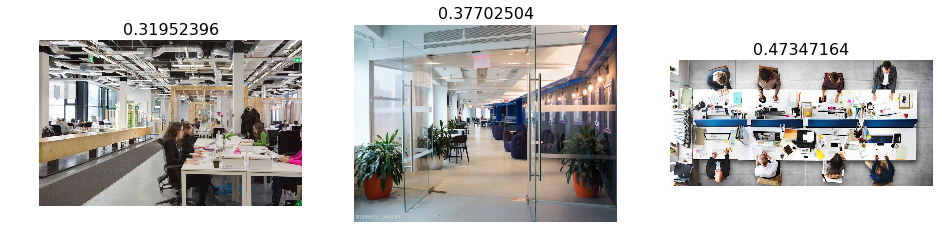

In [83]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect offices")

Most uncertain predictions


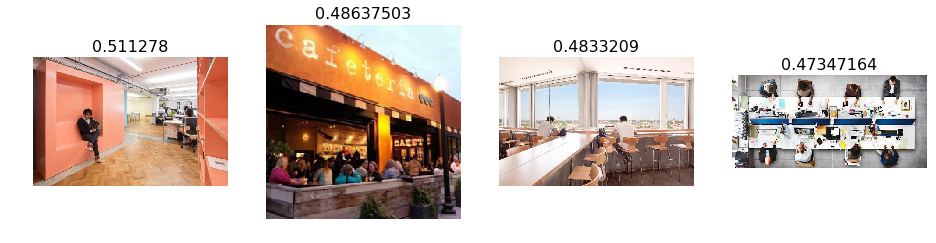

In [84]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

# Part 2

### Implement simple resnet in pytorch

In [4]:
# pytorch tutorial - using a different env from Part 1
import torch

In [5]:
torch.__version__

'0.4.1'

In [9]:
x = torch.empty(5, 3)
x

tensor([[ 0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [10]:
x = torch.rand(5, 3)
x

tensor([[0.0961, 0.6897, 0.9007],
        [0.9842, 0.4726, 0.6873],
        [0.2390, 0.5338, 0.8654],
        [0.5711, 0.0449, 0.0628],
        [0.9625, 0.6687, 0.4388]])

In [13]:
x = torch.zeros((5,3), dtype=torch.long)
x

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [15]:
x = torch.tensor([5.444, 3.444])
x

tensor([5.4440, 3.4440])

In [16]:
x.shape

torch.Size([2])

In [18]:
x = x.new_ones(5, 3,dtype=torch.double)
print(x)

y = torch.rand_like(x, dtype=torch.float)
print(y)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
tensor([[0.8635, 0.6653, 0.5128],
        [0.5649, 0.8022, 0.2150],
        [0.0924, 0.7695, 0.7179],
        [0.7059, 0.9303, 0.3819],
        [0.5183, 0.1319, 0.0602]])


In [20]:
print(x.shape, y.shape)

torch.Size([5, 3]) torch.Size([5, 3])
